In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as sg

import torch
import torch.nn as nn
import torch.nn.functional as F


import mne.time_frequency

In [2]:
eeg_id = 1001369401
path_fif = f'data/{eeg_id}_eeg.fif'

raw = mne.io.read_raw_fif(path_fif, preload=True)#, verbose=False)
start_seconds, stop_seconds = 20, 30
sfreq = raw.info['sfreq']
data = raw.get_data(picks=['eeg'], start=round(start_seconds * sfreq), stop=round(stop_seconds * sfreq))
epoch_data = np.expand_dims(data, 0) * 1e6
# epoch_data_mv = epoch_data * 1e6

freq_low = 2
freq_high = 40
n_freq = 40
freq_type = 'log'
n_cycles = 7.0

Opening raw data file data/1001369401_eeg.fif...
    Range : 0 ... 11199 =      0.000 ...    55.995 secs
Ready.
Reading 0 ... 11199  =      0.000 ...    55.995 secs...


# MNE mne.time_frequency.tfr_array_morlet

In [3]:
if freq_type == 'log':
    freqs = np.logspace(*np.log10([freq_low, freq_high]), num=n_freq)
elif freq_type == 'linear':
    freqs = np.linspace(freq_low, freq_high, num=n_freq)

epoch_data_tf = mne.time_frequency.tfr_array_morlet(
    epoch_data = epoch_data,
    sfreq = sfreq,
    freqs = freqs,
    n_cycles = 7,
    # verbose = False,
)

data_power = np.abs(epoch_data_tf)[0]**2
data_logpower = np.log(data_power + np.finfo(data_power.dtype).eps)

1595.6555012914134


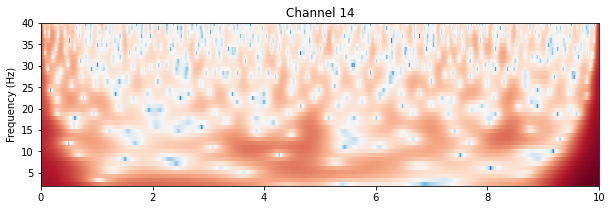

In [4]:
channels = np.asarray([13])
n_channels = len(channels)
fig, axes = plt.subplots(n_channels, 1, figsize=(10, n_channels * 3))
times = np.linspace(0, stop_seconds - start_seconds, data_logpower.shape[-1])

for i, channel in enumerate(channels):
    power = data_logpower[channel]
    power1 = power
    print(np.linalg.norm(power))
    
    ax = axes[i] if n_channels > 1 else axes
    im = ax.imshow(
        power, aspect='auto', origin='lower',
        extent=[times[0], times[-1], freqs[0], freqs[-1]],
        cmap='RdBu_r', interpolation='None'
    )

    # Add labels and title
    ax.set_title(f'Channel {channel+1}')
    ax.set_ylabel('Frequency (Hz)')

# CWTLayer

In [5]:
def to_tensor(x, dtype=torch.float32):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=dtype)
    elif x.dtype != torch.float32:
        x = x.clone().detach().to(dtype=dtype)
    return x

In [6]:
class CWTLayer(nn.Module):
    def __init__(self, freq_low=2, freq_high=40, n_freq=40, srate=200, freq_type='log', n_cycles=7.0, n_sigma=5, n_cycles_type='fixed', q=1, filt_norm=True):
        super().__init__()

        self.srate = srate
        self.n_sigma = n_sigma
        self.n_cycles_type = n_cycles_type
        self.bias = math.log(math.exp(n_cycles) - 1)
        self.q = q
        self.filt_norm = filt_norm
        
        self.register_buffer('_freqs', torch.logspace(math.log10(freq_low), math.log10(freq_high), steps=n_freq))

        n_cycles = torch.tensor(n_cycles, dtype=torch.float32)
        if self.n_cycles_type == 'multiple':
            n_cycles = n_cycles.repeat(n_freq)
        ln_cycles = torch.log(torch.exp(n_cycles) - 1) - self.bias
    
        if self.n_cycles_type == 'fixed':
            self.register_buffer('_ln_cycles', ln_cycles)
        elif (self.n_cycles_type == 'single') or (self.n_cycles_type == 'multiple'):
            self._ln_cycles = nn.Parameter(ln_cycles)
        
        self.softplus = nn.Softplus()

        
    def _create_filters(self):
        n_cycles = self.softplus(self._ln_cycles + self.bias)
        sigma = n_cycles / (2.0 * math.pi * self._freqs)
        sigma = sigma.reshape((-1,1,1,1))
        
        n_timestemps = (self.n_sigma * torch.max(sigma) * self.srate).to(int).item()
        scale = torch.arange(-n_timestemps, n_timestemps+1) / self.srate
        scale = scale.reshape((1,1,1,-1))
        
        freqs = self._freqs.reshape((-1,1,1,1))

        scaling_factor = (2 * math.pi)**(-1/2) * sigma / (self.srate / 2)
        oscillation = torch.exp(1j*2*math.pi * freqs * scale) - torch.exp(-0.5*(2*math.pi * freqs)**2)
        gaussian_envelope = torch.exp(- scale**2 / (2.0 * sigma**2))

        filt = scaling_factor * oscillation * gaussian_envelope
        if self.filt_norm:
            filt /= math.sqrt(0.5) * torch.linalg.norm(filt, dim=-1, keepdim=True)
        return filt, n_timestemps   
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        filt, n_timestemps = self._create_filters()
        x = F.pad(x, pad=(n_timestemps, n_timestemps, 0, 0), mode='constant', value=0)
        x = x.to(torch.complex64)
        x = F.conv2d(x, filt, padding='valid', stride=self.q)
        x = torch.abs(x)
        return x

In [34]:
# fixed, single, multiple
cwt = CWTLayer(
    freq_low=2, 
    freq_high=40, 
    n_freq=40, 
    srate=200, 
    freq_type='log', 
    n_cycles=7.0, 
    n_sigma=5,
    n_cycles_type='multiple',
    filt_norm=True,
)

epoch_data_torch = torch.tensor(epoch_data, dtype=torch.float32)
amplitude = cwt(epoch_data_torch)
logpower = 2 * torch.log(torch.clip(amplitude, min=torch.finfo().eps))
print(torch.norm(torch.abs(logpower)))

tensor(7094.2510, grad_fn=<CopyBackwards>)


1595.6554


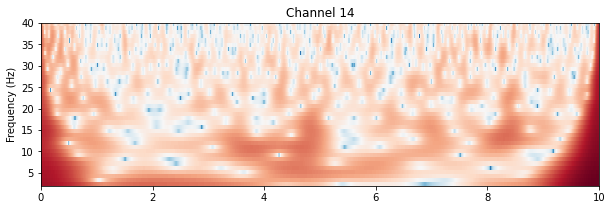

In [40]:
logpower_numpy = logpower.detach().numpy()

channels = np.asarray([13])
n_channels = len(channels)
fig, axes = plt.subplots(n_channels, 1, figsize=(10, n_channels * 3))
times = np.linspace(0, stop_seconds - start_seconds, data_power.shape[-1])

for i, channel in enumerate(channels):
    power = logpower_numpy[:,channel]
    power3 = power
    print(np.linalg.norm(power))
    
    ax = axes[i] if n_channels > 1 else axes
    im = ax.imshow(
        power, aspect='auto', origin='lower',
        extent=[times[0], times[-1], freqs[0], freqs[-1]],
        cmap='RdBu_r', interpolation='None'
    )

    # Add labels and title
#     ax.set_yscale('log')
    ax.set_title(f'Channel {channel+1}')
    ax.set_ylabel('Frequency (Hz)')
    
# np.linalg.norm(power1 - power3) / np.linalg.norm(power1)

In [9]:
class CWTLayerR(nn.Module):
    def __init__(self, freq_low=2, freq_high=40, n_freq=40, srate=200, freq_type='log', n_cycles=7.0, n_sigma=5, n_cycles_type='fixed', q=1):
        super().__init__()

        self.srate = srate
        self.n_sigma = n_sigma
        self.n_cycles_type = n_cycles_type
        self.bias = math.log(math.exp(n_cycles) - 1)
        self.q = q
        
        self.register_buffer('_freqs', torch.logspace(math.log10(freq_low), math.log10(freq_high), steps=n_freq))

        n_cycles = torch.tensor(n_cycles, dtype=torch.float32)
        if self.n_cycles_type == 'multiple':
            n_cycles = n_cycles.repeat(n_freq)
        ln_cycles = torch.log(torch.exp(n_cycles) - 1) - self.bias
    
        if self.n_cycles_type == 'fixed':
            self.register_buffer('_ln_cycles', ln_cycles)
        elif (self.n_cycles_type == 'single') or (self.n_cycles_type == 'multiple'):
            self._ln_cycles = nn.Parameter(ln_cycles)
        
        self.softplus = nn.Softplus()
        
        
    def _create_filters(self):
        n_cycles = self.softplus(self._ln_cycles + self.bias)
        sigma = n_cycles / (2.0 * math.pi * self._freqs)
        sigma = sigma.reshape((-1,1,1,1))
        
        n_timestemps = (self.n_sigma * torch.max(sigma) * self.srate).to(int).item()
        scale = torch.arange(-n_timestemps, n_timestemps+1) / self.srate
        scale = scale.reshape((1,1,1,-1))
        
        freqs = self._freqs.reshape((-1,1,1,1))

        scaling_factor = (2 * math.pi)**(-1/2) * sigma / (self.srate / 2)
        oscillation_sin = torch.sin(2*math.pi * freqs * scale) - torch.exp(-0.5*(2*math.pi * freqs)**2)
        oscillation_cos = torch.cos(2*math.pi * freqs * scale) - torch.exp(-0.5*(2*math.pi * freqs)**2)
        gaussian_envelope = torch.exp(- scale**2 / (2.0 * sigma**2))

        filt_sin = scaling_factor * oscillation_sin * gaussian_envelope
        filt_sin /= torch.linalg.norm(filt_sin, dim=-1, keepdim=True)
        filt_cos = scaling_factor * oscillation_cos * gaussian_envelope
        filt_cos /= torch.linalg.norm(filt_cos, dim=-1, keepdim=True)
        filt = torch.cat([filt_sin, filt_cos], dim=0)
        return filt, n_timestemps   
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        filt, n_timestemps = self._create_filters()
        x = F.pad(x, pad=(n_timestemps, n_timestemps, 0, 0), mode='constant', value=0)
        x = F.conv2d(x, filt, padding='valid', stride=self.q)

        shape = list(x.shape)
        shape.insert(-2, shape[-3] // 2) 
        shape[-4] = 2
        x = x.reshape(shape)
        x = torch.norm(x, dim=-4)
#         x = torch.norm(torch.stack(torch.split(x, x.shape[-3] // 2, dim=-3)), dim=0)
        return x

In [10]:
# fixed, single, multiple
cwt = CWTLayerR(n_cycles=7, n_cycles_type='multiple')
amplitude = cwt(epoch_data_torch)
logpower = 2 * torch.log(torch.clip(torch.abs(amplitude), min=torch.finfo().eps))
print(torch.norm(torch.abs(logpower)))

tensor(7094.2510, grad_fn=<CopyBackwards>)


1595.6554


3.177956734027157e-05

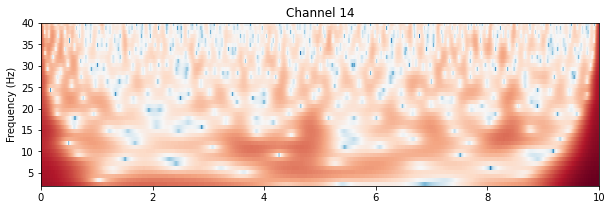

In [11]:
logpower_numpy = logpower.detach().numpy()

channels = np.asarray([13])
n_channels = len(channels)
fig, axes = plt.subplots(n_channels, 1, figsize=(10, n_channels * 3))
times = np.linspace(0, stop_seconds - start_seconds, data_power.shape[-1])

for i, channel in enumerate(channels):
    power = logpower_numpy[:,channel]
    power3 = power
    print(np.linalg.norm(power))
    
    ax = axes[i] if n_channels > 1 else axes
    im = ax.imshow(
        power, aspect='auto', origin='lower',
        extent=[times[0], times[-1], freqs[0], freqs[-1]],
        cmap='RdBu_r', interpolation='None'
    )

    # Add labels and title
    ax.set_title(f'Channel {channel+1}')
    ax.set_ylabel('Frequency (Hz)')
    
np.linalg.norm(power1 - power3) / np.linalg.norm(power1)